<a href="https://colab.research.google.com/github/dickyadem/herbal-leaf-classification-with-Resnet-152-using-Pytorch/blob/main/herbal_leaf_classification_with_Resnet_152_using_Pytorch_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Herbal Classification 



In [1]:
import numpy as np 
import pandas as pd
import os
import torch
import torchvision
import tarfile
import torchvision
from torch.utils.data import random_split
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision.transforms import ToTensor
from torch.utils.data.dataloader import DataLoader
import torch.nn as nn
from torchvision.utils import make_grid
import torchvision.models as models
import torch.nn.functional as F
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
from google.colab import drive
drive.mount("/content/drive/")



Mounted at /content/drive/


In [4]:
!unzip '/content/drive/My Drive/HerbalLeaf.zip' -d '/content/dataset-tanaman-herbal'

Archive:  /content/drive/My Drive/HerbalLeaf.zip
  inflating: /content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (100).JPG  
  inflating: /content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (81).JPG  
  inflating: /content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (82).JPG  
  inflating: /content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (83).JPG  
  inflating: /content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (84).JPG  
  inflating: /content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (85).JPG  
  inflating: /content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (86).JPG  
  inflating: /content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing/Daun Jambu Biji/jambu biji (87).JPG 

In [6]:
data_train ="/content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Training"
data_test ="/content/dataset-tanaman-herbal/DATASET TANAMAN HERBAL/Data Testing"

In [7]:
transformer = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
transformer1 = torchvision.transforms.Compose(
    [  # Applying Augmentation
        torchvision.transforms.Resize((224, 224)),
        torchvision.transforms.RandomHorizontalFlip(p=0.5),
        torchvision.transforms.RandomVerticalFlip(p=0.5),
        torchvision.transforms.RandomRotation(40),
        torchvision.transforms.ToTensor(),
        torchvision.transforms.Normalize(
            mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010]
        ),
    ]
)
dat_train = ImageFolder(data_train, transform=transformer)
dat_test = ImageFolder(data_test, transform=transformer1)

In [8]:
dat_train.classes

['Daun Jambu Biji',
 'Daun Kari',
 'Daun Kemangi',
 'Daun Kunyit',
 'Daun Mint',
 'Daun Pepaya',
 'Daun Sirih',
 'Daun Sirsak',
 'Lidah Buaya',
 'Teh Hijau']

In [9]:
herb_name_dict={'Daun Jambu Biji':0, 'Daun Kari':1, 'Daun Kemangi':2, 'Daun Kunyit':3, 'Daun Mint':4, 'Daun Pepaya':5, 'Daun Sirih':6, 'Daun Sirsak':7, 'Lidah Buaya':8, 'Teh Hijau':9}

def encode_label(img_label):
    return herb_name_dict[img_label] 

In [10]:
herb_label = {
   0: 'Daun Jambu Biji', 1: 'Daun Kari', 2: 'Daun Kemangi', 3:'Daun Kunyit', 4:'Daun Mint',5: 'Daun Pepaya',6: 'Daun Sirih',7: 'Daun Sirsak',8: 'Lidah Buaya', 9:'Teh Hijau'
}

#Val_set and train_set

In [11]:
batch_size=32

In [12]:
train_dl = DataLoader(dat_train, batch_size , shuffle=True)
val_dl = DataLoader(dat_test,batch_size)
test_dl = DataLoader(dat_test, batch_size)

# 1. Training Image Classification   

In [13]:
def accuracy(outputs, labels):
    _, preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

class ImageClassification(nn.Module):
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)
        loss = F.cross_entropy(out, labels)
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    
        loss = F.cross_entropy(out, labels)   
        acc = accuracy(out, labels)           
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))

In [14]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

def fit(epochs, lr, model, train_loader, val_loader, opt_func=torch.optim.SGD):
    history = []
    optimizer = opt_func(model.parameters(), lr)
    for epoch in range(epochs):
        # Training Phase 
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
        # Validation phase
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    return history


# Get GPU up on running

In [15]:
def get_default_device():
    """Pick GPU if available, else CPU"""
    if torch.cuda.is_available():
        return torch.device('cuda')
    else:
        return torch.device('cpu')
    
def to_device(data, device):
    """Move tensor(s) to chosen device"""
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
    """Wrap a dataloader to move data to a device"""
    def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
    def __iter__(self):
        """Yield a batch of data after moving it to device"""
        for b in self.dl: 
            yield to_device(b, self.device)

    def __len__(self):
        """Number of batches"""
        return len(self.dl)

device = get_default_device()

In [16]:
device = get_default_device()
device

device(type='cuda')

# Training and Validation Dataset

In [17]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)
test_dl = DeviceDataLoader(test_dl, device)

# 2. Resnet 152

In [18]:
class HerbModelResnet152(ImageClassification):
    def __init__(self):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet152(pretrained=True)
        # Replace last layer
        num_ftrs = self.network.fc.in_features
        self.network.fc = nn.Linear(num_ftrs, 10)
        
    def forward(self, xb):
        return torch.sigmoid(self.network(xb))

In [19]:
model = to_device(HerbModelResnet152(), device)
evaluate(model, val_dl)

Downloading: "https://download.pytorch.org/models/resnet152-394f9c45.pth" to /root/.cache/torch/hub/checkpoints/resnet152-394f9c45.pth


  0%|          | 0.00/230M [00:00<?, ?B/s]

{'val_acc': 0.09375, 'val_loss': 2.3240325450897217}

In [22]:
epochs = 10
opt_func_1 = torch.optim.Adam
lr_1 = 0.001

In [23]:
%%time
try2 = fit(epochs, lr_1, model, train_dl, val_dl, opt_func_1)

Epoch [0], train_loss: 1.6230, val_loss: 1.8203, val_acc: 0.6116
Epoch [1], train_loss: 1.5575, val_loss: 1.8512, val_acc: 0.5848
Epoch [2], train_loss: 1.5395, val_loss: 1.6948, val_acc: 0.7545
Epoch [3], train_loss: 1.5254, val_loss: 1.6446, val_acc: 0.7812
Epoch [4], train_loss: 1.5213, val_loss: 1.6206, val_acc: 0.7723
Epoch [5], train_loss: 1.5302, val_loss: 1.8166, val_acc: 0.6473
Epoch [6], train_loss: 1.5377, val_loss: 1.6614, val_acc: 0.7634
Epoch [7], train_loss: 1.5373, val_loss: 1.7553, val_acc: 0.6562
Epoch [8], train_loss: 1.5356, val_loss: 1.6776, val_acc: 0.7589
Epoch [9], train_loss: 1.5300, val_loss: 1.6085, val_acc: 0.8214
CPU times: user 42min 17s, sys: 2min 15s, total: 44min 32s
Wall time: 44min 23s


In [24]:
evaluate(model, test_dl)

{'val_acc': 0.8392857313156128, 'val_loss': 1.6100386381149292}

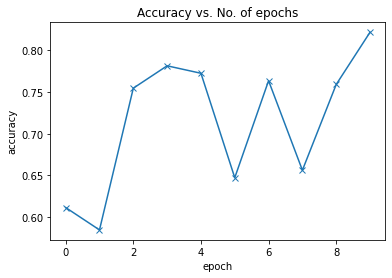

In [25]:
def plot_accuracies(try2):
    accuracies = [x['val_acc'] for x in try2]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

plot_accuracies(try2)

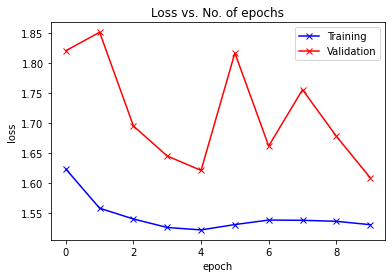

In [26]:
def plot_losses(try2):
    train_losses = [x.get('train_loss') for x in try2]
    val_losses = [x['val_loss'] for x in try2]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');
plot_losses(try2)

In [28]:
def predict_image(img, model):
    xb = img.unsqueeze(0)
    yb = model(xb)
    _, preds  = torch.max(yb, dim=1)
    return herb_label[preds[0].item()]

# Prediksi resnet 152

Label: Teh Hijau , Predicted: Teh Hijau


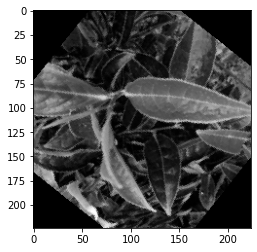

In [42]:
img, label = dat_test[199]
plt.imshow(img[0], cmap='gray')
print('Label:', dat_test.classes[label], ', Predicted:', predict_image(img, HerbModelResnet152()))